In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/masters


# Model Comparisons
This notebooks is used to display the model results of different models on certain datasets. Provided with the T, X, and Y dimensions of the data the

In [11]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.plots import DistributionPlotter
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, CellPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report
import pickle
from utils.utils import pshape
from pprint import pprint
from utils.configs import BaseConf
from models.model_result import save_metrics, compare_models,get_metrics_table, get_models_metrics, get_models_results
from utils.plots import DistributionPlotter

In [2]:
%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred, plot_roc_and_pr_curve
from models.model_result import ModelResult, ModelMetrics, save_metrics
from models.baseline_models import ExponentialMovingAverage,\
                UniformMovingAverage, TriangularMovingAverage, HistoricAverage
from models.model_result import get_metrics_table, get_models_metrics, get_models_results, get_models_metrics, \
                get_all_metrics
from utils.utils import pshape, get_data_sub_paths

In [3]:
import pandas as pd
import itertools

In [4]:
df = get_all_metrics()
# used to group the datatypes and get mean and stddev of the metrics
# result = df.groupby(['Model','dt','dx','dy'], as_index=False).agg(
#                       {
#                         'ROC AUC':['mean','std'],
#                         'Avg. Precision':['mean','std'],
#                         'Precision':['mean','std'],
#                         'Recall':['mean','std'],
#                         'F1 Score':['mean','std'],
#                         'Accuracy':['mean','std'],
#                         'Matthews Corrcoef':['mean','std'],
#                       })

# result = df.sort_values(['dt','dx','dy','Avg. Precision'],ascending=False)
# result[result.dt == 24]

In [5]:
df

,Model,dt,dx,dy,start_date,stop_date,MAE,RMSE,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,Matthews Corrcoef
20,Historic Average,24,850,880,2013-01-01,2017-01-01,0.418447,0.568508,0.780098,0.732258,0.605011,0.818631,0.695794,0.681919,0.397014
24,Global Average,24,850,880,2013-01-01,2017-01-01,0.418421,0.568439,0.779865,0.731426,0.591743,0.847433,0.696875,0.672406,0.392381
23,Ind-Hawkes Model,24,850,880,2013-01-01,2017-01-01,0.366839,0.440295,0.778742,0.730925,0.601215,0.824637,0.695421,0.679020,0.394371
21,Hawkes General Model,24,850,880,2013-01-01,2017-01-01,0.437985,0.610298,0.750134,0.702386,0.569609,0.833355,0.676691,0.646149,0.343593
22,Previous Time Step,24,850,880,2013-01-01,2017-01-01,0.418037,0.582188,0.645914,0.571206,0.444358,1.000000,0.615302,0.444358,0.000000
41,Historic Average,24,850,880,2013-01-01,2015-01-01,0.415614,0.553971,0.787064,0.746747,0.599152,0.851656,0.703431,0.677703,0.401255
45,Global Average,24,850,880,2013-01-01,2015-01-01,0.415520,0.553563,0.786669,0.745822,0.591271,0.865153,0.702460,0.671070,0.396162
44,Ind-Hawkes Model,24,850,880,2013-01-01,2015-01-01,0.362040,0.434897,0.785556,0.744800,0.593397,0.856850,0.701194,0.672250,0.394493
42,Hawkes General Model,24,850,880,2013-01-01,2015-01-01,0.440539,0.563276,0.765040,0.725576,0.580852,0.843224,0.687869,0.656551,0.363024
43,Previous Time Step,24,850,880,2013-01-01,2015-01-01,0.415492,0.574001,0.653737,0.585656,0.448804,1.000000,0.619551,0.448804,0.000000


In [6]:
data_sub_paths = get_data_sub_paths()
np.sort(data_sub_paths)

array(['T12H-X850M-Y880M_2013-01-01_2015-01-01',
       'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
       'T1H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X255M-Y220M_2013-01-01_2015-01-01',
       'T24H-X425M-Y440M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2017-01-01',
       'T24H-X85M-Y110M_2013-01-01_2015-01-01',
       'T3H-X850M-Y880M_2013-01-01_2015-01-01',
       'T6H-X850M-Y880M_2013-01-01_2015-01-01'], dtype='<U39')

In [7]:
data_sub_paths = [
    'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
    'T1H-X850M-Y880M_2013-01-01_2015-01-01',
    'T3H-X850M-Y880M_2013-01-01_2015-01-01',
    'T6H-X850M-Y880M_2013-01-01_2015-01-01',
    'T12H-X850M-Y880M_2013-01-01_2015-01-01',
    'T24H-X850M-Y880M_2013-01-01_2015-01-01',
    'T24H-X425M-Y440M_2013-01-01_2015-01-01',
    'T24H-X255M-Y220M_2013-01-01_2015-01-01',
    'T24H-X85M-Y110M_2013-01-01_2015-01-01',
]


In [8]:
data_sub_paths = ["T24H-X850M-Y880M_2013-01-01_2015-01-01",'T3H-X850M-Y880M_2013-01-01_2015-01-01']

In [9]:
pd.set_option('display.max_columns', None)

In [9]:
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    conf.data_path = f"./data/processed/{data_sub_path}/" 
    print("===========================================================================================")
    print(data_sub_path)
    print("===========================================================================================")
    models_metrics = get_models_metrics(conf.data_path)
    table = get_metrics_table(models_metrics)
    print(table)

T24H-X850M-Y880M_2013-01-01_2015-01-01
                       ROC AUC  Avg. Precision  Precision    Recall  F1 Score  \
Model Name                                                                      
Historic Average      0.785866        0.746661   0.587615  0.873425  0.702565   
Global Average        0.786672        0.745822   0.591271  0.865153  0.702460   
Ind-Hawkes Model      0.785594        0.744993   0.591839  0.859383  0.700949   
RFNN                  0.784034        0.743637   0.597967  0.848706  0.701607   
ST-RESNET             0.779583        0.738947   0.573003  0.890193  0.697218   
ST-RESNET-Extra       0.769548        0.733298   0.605537  0.823282  0.697818   
LR (CMP)              0.775626        0.728170   0.592779  0.851624  0.699008   
LR (TMP+SPC+ENV)      0.774368        0.727405   0.595878  0.842551  0.698064   
Hawkes General Model  0.764797        0.725320   0.583471  0.837485  0.687774   
Kang FNN              0.763432        0.722039   0.580078  0.847809  0

T24H-X850M-Y880M_2013-01-01_2015-01-01
                       ROC AUC  Avg. Precision  Precision    Recall  F1 Score  \
Model Name                                                                      
Historic Average      0.753655        0.246152   0.227663  0.452580  0.302938   
Ind-Hawkes Model      0.732156        0.229147   0.213494  0.428389  0.284970   
ST-RESNET             0.732505        0.228389   0.205528  0.441507  0.280486   
ST-RESNET-Extra       0.721754        0.222926   0.205863  0.428997  0.278218   
Global Average        0.731416        0.210335   0.193046  0.487095  0.276506   
Hawkes General Model  0.699960        0.190031   0.190952  0.387133  0.255754   
Previous Time Step    0.545570        0.105401   0.170390  0.170307  0.170348   

                      Accuracy  Matthews Corrcoef  
Model Name                                         
Historic Average      0.816567           0.226921  
Ind-Hawkes Model      0.810666           0.205045  
ST-RESNET             0

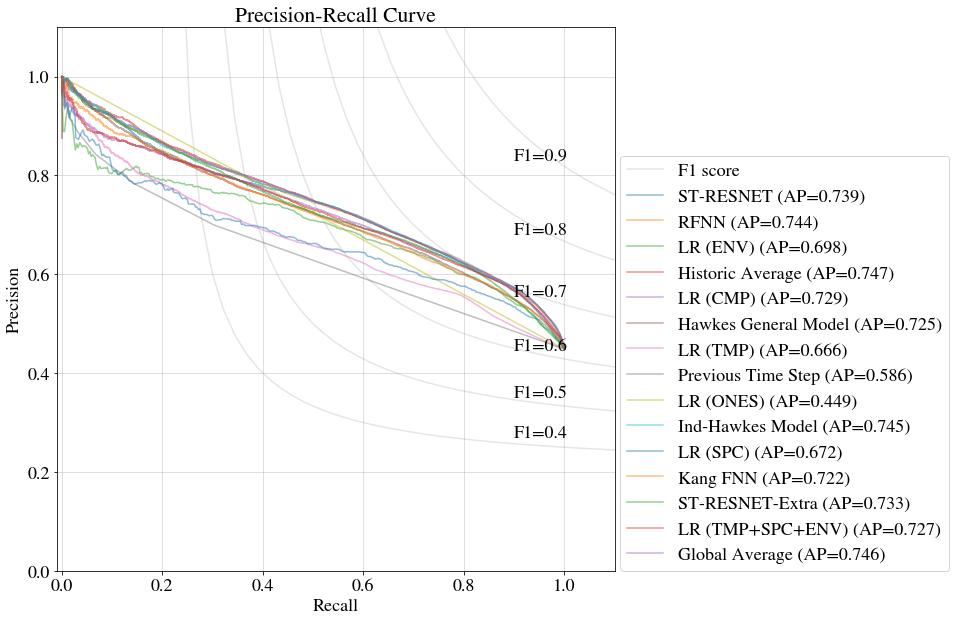

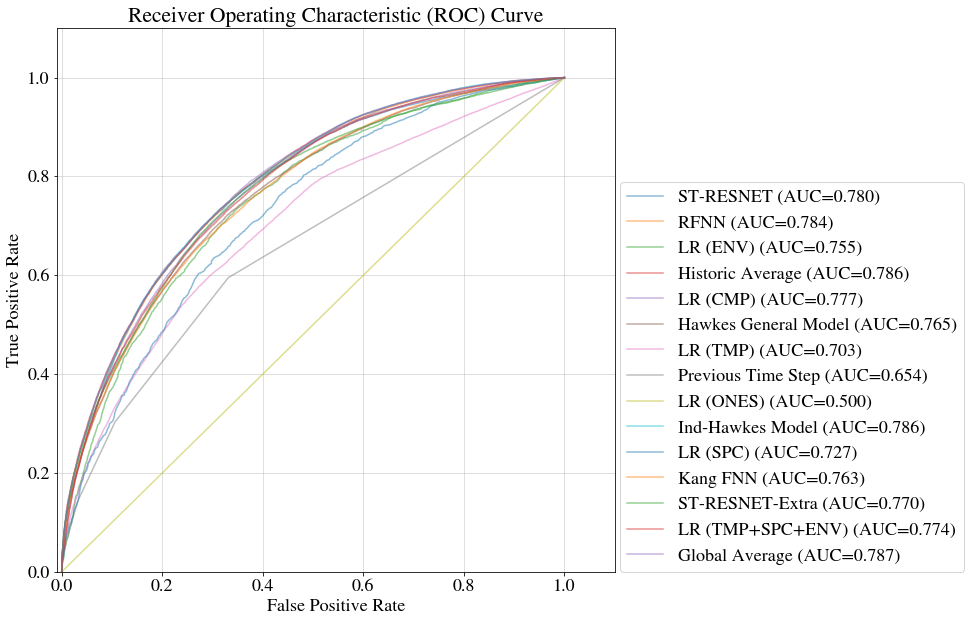

T3H-X850M-Y880M_2013-01-01_2015-01-01
                       ROC AUC  Avg. Precision  Precision    Recall  F1 Score  \
Model Name                                                                      
Historic Average      0.753655        0.246152   0.227663  0.452580  0.302938   
Ind-Hawkes Model      0.732156        0.229147   0.213494  0.428389  0.284970   
ST-RESNET             0.732505        0.228389   0.205528  0.441507  0.280486   
ST-RESNET-Extra       0.721754        0.222926   0.205863  0.428997  0.278218   
Global Average        0.731416        0.210335   0.193046  0.487095  0.276506   
Hawkes General Model  0.699960        0.190031   0.190952  0.387133  0.255754   
Previous Time Step    0.545570        0.105401   0.170390  0.170307  0.170348   

                      Accuracy  Matthews Corrcoef  
Model Name                                         
Historic Average      0.816567           0.226921  
Ind-Hawkes Model      0.810666           0.205045  
ST-RESNET             0.

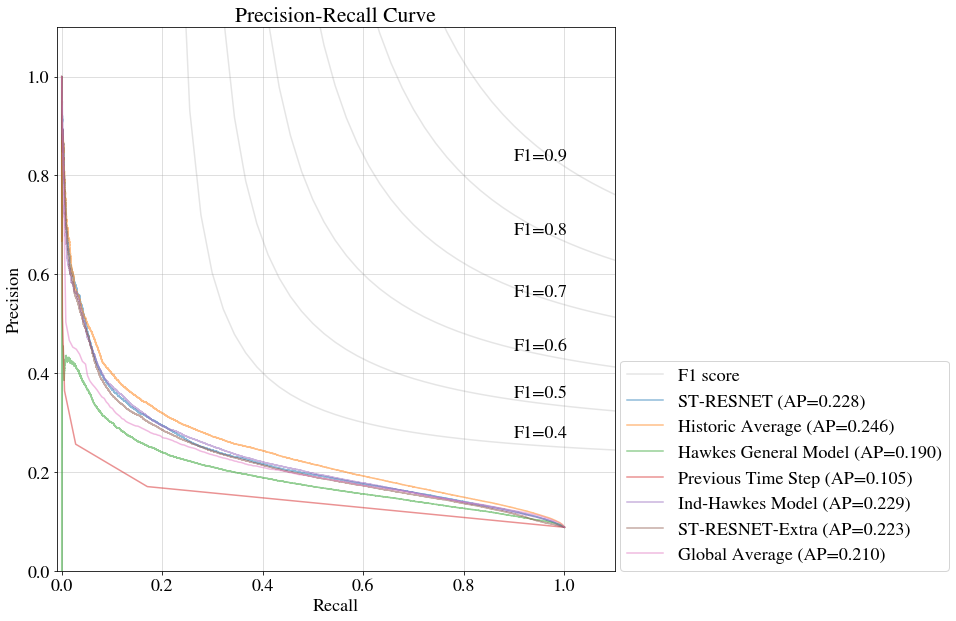

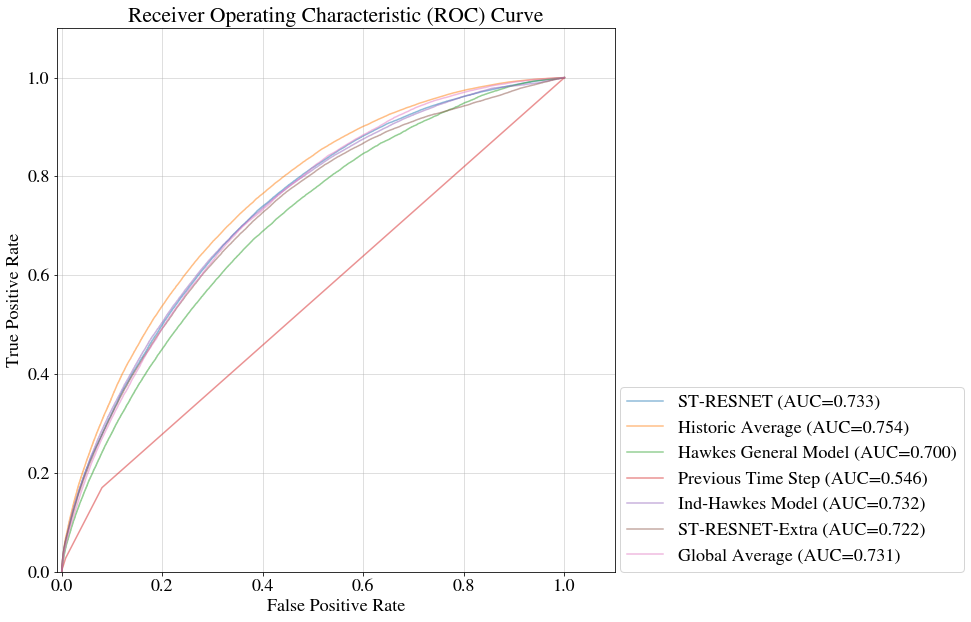

In [8]:
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    conf.data_path = f"./data/processed/{data_sub_path}/" 
    print("===========================================================================================")
    print(data_sub_path)
    print("===========================================================================================")
    print(str(table.__str__()))
    compare_models(conf.data_path)

In [12]:
data_sub_paths = get_data_sub_paths()
pprint(data_sub_paths)
data_sub_path = 'T24H-X255M-Y220M_2013-01-01_2015-01-01'

conf = BaseConf()
conf.data_path = f"./data/processed/{data_sub_path}/" 
models_metrics = get_models_metrics(conf.data_path)

['T3H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X85M-Y110M_2013-01-01_2015-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
 'T12H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2017-01-01',
 'T24H-X255M-Y220M_2013-01-01_2015-01-01',
 'T6H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X425M-Y440M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2015-01-01',
 'T1H-X850M-Y880M_2013-01-01_2015-01-01']


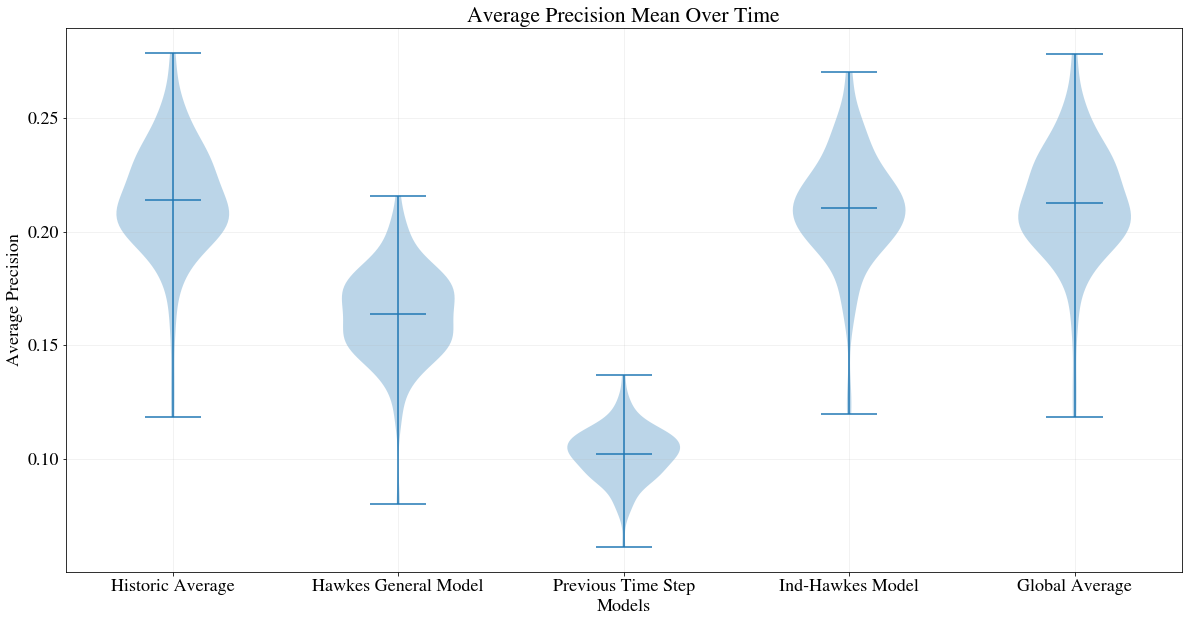

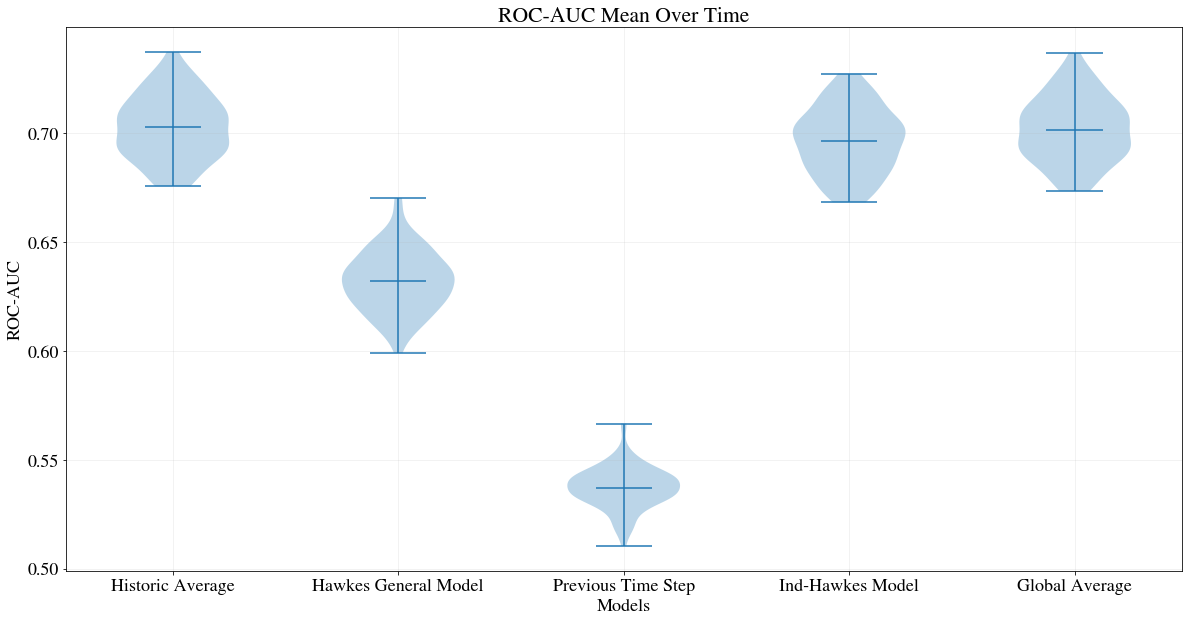

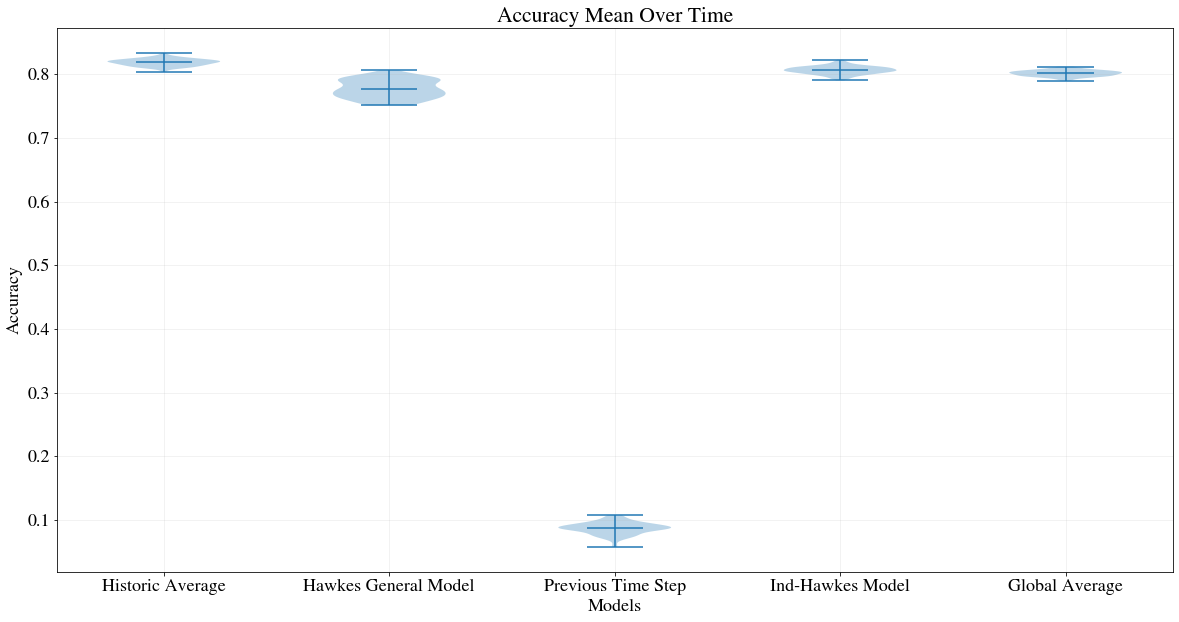

In [19]:
# Average Precision over Time
labels = []
data = []
for m in models_metrics:
    labels.append(m.model_name)
    data.append(m.ap_per_time.flatten())
    

dist_plot = DistributionPlotter(title="Average Precision Mean Over Time",
                                xlabel="Models",
                                ylabel="Average Precision",
                                is_box_plot=False)

dist_plot.add_data(data=data, labels=labels) 
dist_plot.show()


# ROC over Time
labels = []
data = []
for m in models_metrics:
    labels.append(m.model_name)
    data.append(m.roc_per_time.flatten())
    
dist_plot = DistributionPlotter(title="ROC-AUC Mean Over Time",
                                xlabel="Models",
                                ylabel="ROC-AUC",
                                is_box_plot=False)
dist_plot.add_data(data=data, labels=labels)
dist_plot.show()


# Acc over Time
labels = []
data = []
for m in models_metrics:
    labels.append(m.model_name)
    data.append(m.acc_per_time.flatten())
    
dist_plot = DistributionPlotter(title="Accuracy Mean Over Time",
                                xlabel="Models",
                                ylabel="Accuracy",
                                is_box_plot=False)
dist_plot.add_data(data=data, labels=labels)
dist_plot.show()



In [25]:
m = models_metrics[3]

print(m.model_name)
for k in ['ap_per_time', 'roc_per_time', 'acc_per_time', 'p_per_time', 'r_per_time']:
    val = m.__dict__[k]
    name = k.split('_per_time')[0]
    print(f"{name} over time: {val.mean()} ± {val.std()}")



Ind-Hawkes Model
ap over time: 0.21057447119584843 ± 0.02418668307926679
roc over time: 0.6967108510149138 ± 0.01477579898352518
acc over time: 0.8063676276442234 ± 0.006178446082527667
p over time: 0.1981662686808041 ± 0.022022741438354455
r over time: 0.40110868366867297 ± 0.024278381019228114


In [23]:
m.accuracy_score,m.average_precision_score, m.roc_auc_score

(0.8063676276442234, 0.20768387586047712, 0.6968256307095597)

In [8]:
models_results = get_models_results(conf.data_path)

In [9]:
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, matthews_corrcoef \
    , precision_recall_curve, roc_curve, recall_score, precision_score

class ModelMetrics:  # short memory light way of comparing models - does not save the actually predictions
    def __init__(self, model_name, y_true, y_pred, probas_pred):
        # y_true must be in format N,1,L to be able to correctly compare all the models
        if len(y_true.shape) != 3 or y_true.shape[1] != 1:
            raise Exception(f"y_true must be in (N,1,L) not {y_true.shape}.")

        if len(y_pred.shape) != 3 or y_pred.shape[1] != 1:
            raise Exception(f"y_pred must be in (N,1,L) not {y_pred.shape}.")

        if len(probas_pred.shape) != 3 or probas_pred.shape[1] != 1:
            raise Exception(f"probas_pred must be in (N,1,L) not {probas_pred.shape}.")

        # flatten array for the next functions
        y_true, y_pred, probas_pred = y_true.flatten(), y_pred.flatten(), probas_pred.flatten()
        self.model_name = model_name
        self.accuracy_score = accuracy_score(y_true, y_pred)
        self.roc_auc_score = roc_auc_score(y_true, probas_pred)

        self.recall_score = recall_score(y_true, y_pred)
        self.precision_score = precision_score(y_true, y_pred)

        self.average_precision_score = average_precision_score(y_true, probas_pred)
        self.matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

    def __repr__(self):
        r = rf"""
        MODEL METRICS
            Model Name: {self.model_name}
                ROC AUC:            {self.roc_auc_score}                
                Average Precision:  {self.average_precision_score}
                Precision:          {self.precision_score}
                Recall:             {self.recall_score}
                Accuracy:           {self.accuracy_score}
                MCC:                {self.matthews_corrcoef}          
        """

        return r

    def __str__(self):
        return self.__repr__()

------------------------------------------all cells all times -----------------------------------------


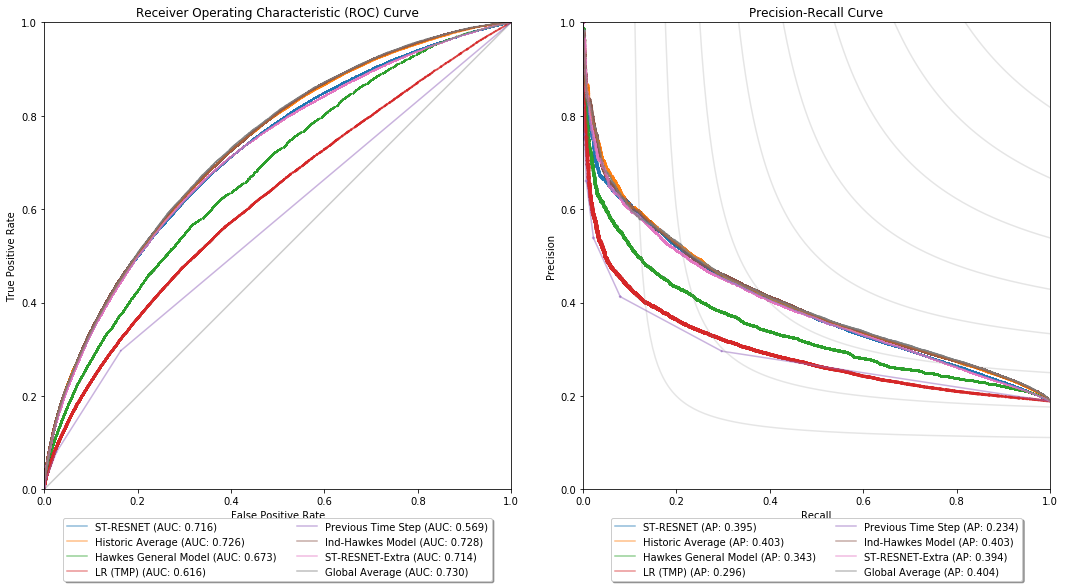

-----------------------------------------------------------------------------------
./data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/
------------------------------------------252-----------------------------------------


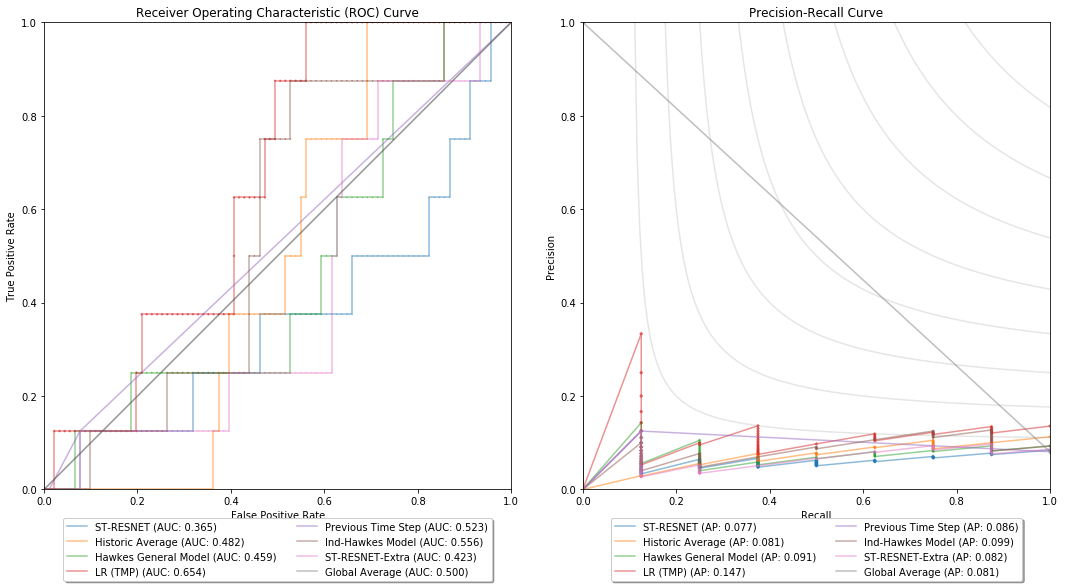

-----------------------------------------------------------------------------------
------------------------------------------539-----------------------------------------


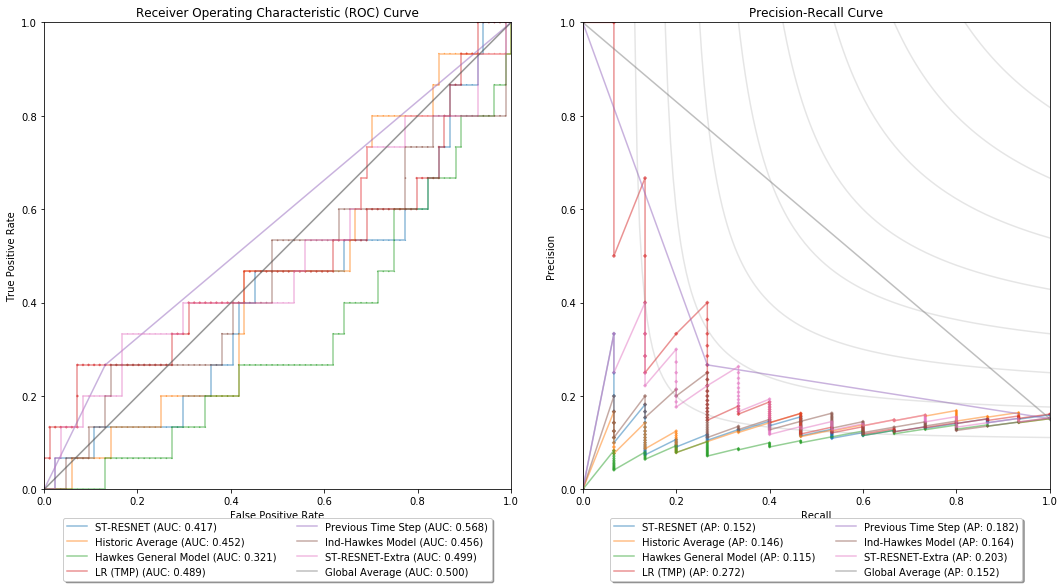

-----------------------------------------------------------------------------------
------------------------------------------856-----------------------------------------


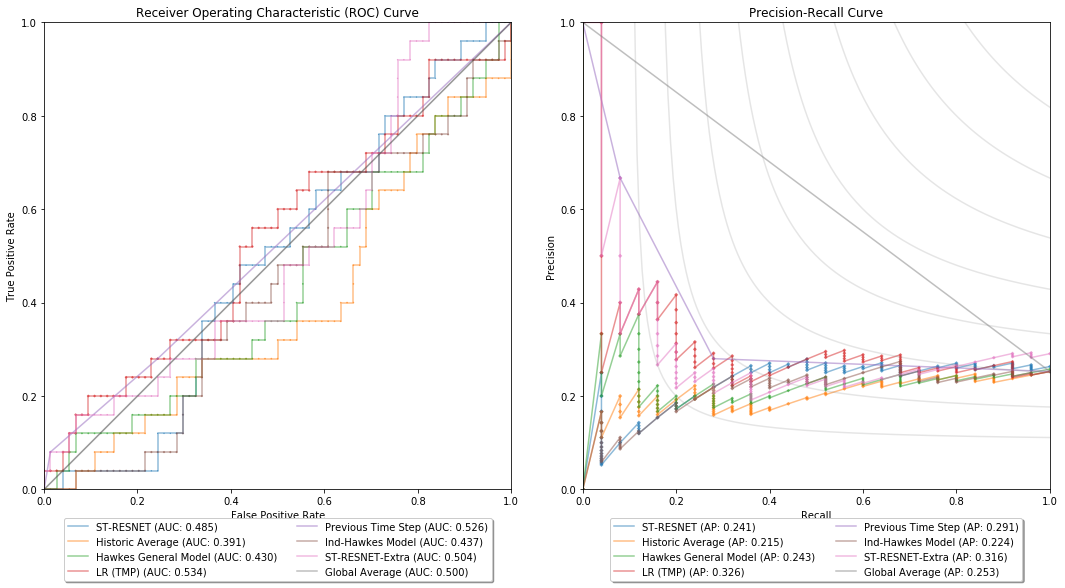

-----------------------------------------------------------------------------------


In [12]:
m = models_results[0]
top_indices = np.argsort(m.y_true.sum(axis=(1,0)))

def norm(x):
#     return x
    x = x - np.min(x)
    x = x / np.max(x)
    return x

print(f"------------------------------------------all cells all times -----------------------------------------")

probas_pred_dict = {}
for m in models_results:    
    y_true, y_pred, probas_pred = m.y_true, m.y_pred, m.probas_pred
    
    probas_pred_dict[m.model_name] = probas_pred.flatten()
plot_roc_and_pr_curve(y_true.flatten(),probas_pred_dict)
print(f"-----------------------------------------------------------------------------------")
print(conf.data_path)
for i in top_indices[[int(0.25*len(top_indices)),int(0.5*len(top_indices)),int(0.75*len(top_indices))]]:
    print(f"------------------------------------------{i}-----------------------------------------")
    lim = 200
    probas_pred_dict = {}
    for m in models_results:    
        y_true, y_pred, probas_pred = m.y_true, m.y_pred, m.probas_pred

        y_true = y_true[:lim,0,i]
        y_pred = y_pred[:lim,0,i]
        probas_pred = probas_pred[:lim,0,i]


    #     ap = average_precision_score(y_true=y_true.flatten(),y_score=probas_pred.flatten())
    #     roc_auc = roc_auc_score(y_true=y_true.flatten(),y_score=probas_pred.flatten())    

    #     model_metrics = ModelMetrics(model_name=f"{m.model_name} (cell:{i})",
    #                  y_true=y_true.reshape((-1,1,1)),
    #                  y_pred=y_pred.reshape((-1,1,1)),
    #                  probas_pred=probas_pred.reshape((-1,1,1)))

    #     plt.figure(figsize=(15,5))
    #     plt.title(m.model_name)
    # #     plt.plot(norm(y_true),label='true (normed)')
    #     plt.plot(y_true,label='true',alpha=.5)

    #     plt.plot(y_pred,label="y_pred",alpha=.5)

    # #     plt.plot(norm(probas_pred),label=f"probas_pred (normed)")
    #     plt.plot(probas_pred,label="probas_pred",alpha=.5)

    #     plt.grid()
    #     plt.legend()
    #     plt.show()

        probas_pred_dict[m.model_name] = probas_pred


    #     print(model_metrics)
    #     print("------------------------------------------------------------------------------------")

    plot_roc_and_pr_curve(y_true, probas_pred_dict)
    print("-----------------------------------------------------------------------------------")

In [11]:
def plot_roc_and_pr_curve(y_true, probas_pred_dict):
    # ROC and PR Are binary so the class should be specified, one-vs-many
    # selecting and setting the class
    fig, (ax0, ax1) = plt.subplots(1, 2,)
    fig.set_figwidth(15)
    fig.set_figheight(10)

    ax0.set_title("Receiver Operating Characteristic (ROC) Curve")  # (AUC = %.4f)"%auc)
    ax0.set_xlabel("False Positive Rate")
    ax0.set_ylabel("True Positive Rate")
    ax0.set_aspect(1)
    ax0.set_xlim(0,1.)
    ax0.set_ylim(0,1.)
    ax1.set_title("Precision-Recall Curve")  # (AUC = %.4f)"%auc)
    ax1.set_ylabel("Precision")
    ax1.set_xlabel("Recall")
    ax1.set_aspect(1.)
    ax1.set_xlim(0,1.)
    ax1.set_ylim(0,1.)    

    for name, probas_pred in probas_pred_dict.items():
        probas_pred = probas_pred.ravel()

        # ROC Curve
        fpr, tpr, thresholds = roc_curve(y_true, probas_pred, drop_intermediate=False)
        thresholds = thresholds / np.max(thresholds)
        auc = roc_auc_score(y_true, probas_pred)
        ax0.plot(fpr, tpr, label=name + " (AUC: %.3f)" % auc, alpha=0.5)
        ax0.scatter(fpr, tpr, alpha=0.5, s=5 * thresholds, marker='D')

        # Precision Recall Curve
        precision, recall, thresholds = precision_recall_curve(y_true, probas_pred)
        thresholds = thresholds / np.max(thresholds)
        ap = average_precision_score(y_true, probas_pred)
        ax1.plot(recall, precision, label=name + " (AP: %.3f)" % ap, alpha=0.5)
        ax1.scatter(recall, precision, alpha=0.5, s=5 * thresholds, marker='D')

    f_scores = [.2,.3,.4,0.5,.6,.7,.8,.9]
    for f_score in f_scores:
        x = np.linspace(0.0001, 1.1,200)
        y = f_score * x / (2 * x - f_score)

        x = x[y >= 0]
        y = y[y >= 0]

    
        l, = ax1.plot(x,y, color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

#     ax0.legend(bbox_to_anchor=(1.01, 0), loc="lower left", borderaxespad=0)
    ax0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=1)
    
    ax0.plot([0, 1], [0, 1], c='k', alpha=0.2)

#     ax1.legend(bbox_to_anchor=(1.01, 0), loc="lower left", borderaxespad=0)
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=1)
    
    
    plt.tight_layout()
    plt.show()
    

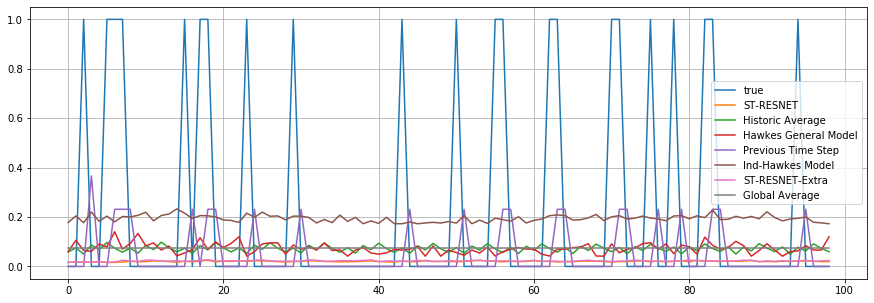

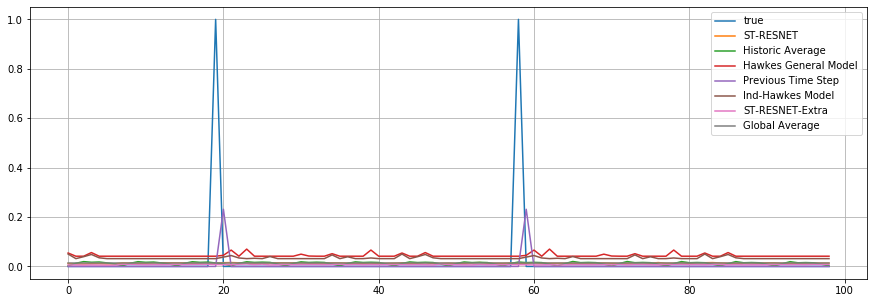

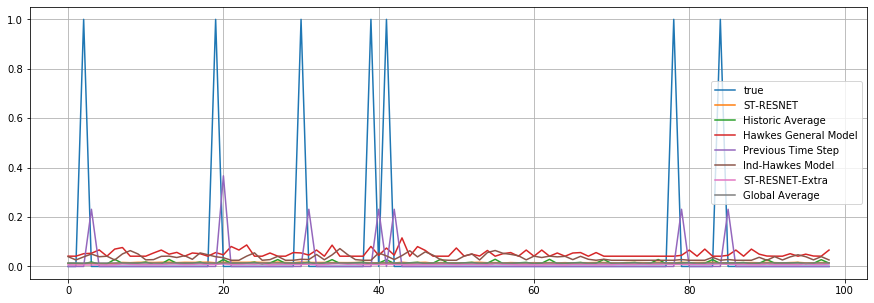

In [17]:
for i in range(3):
    lim = 1000
    plt.figure(figsize=(15,5))
    y_true = m.y_true[:lim,0,i]#.sum(1)
    # plt.plot(norm(y_true),label='true (normed)')
    plt.plot(y_true,label='true')
    for m in models_results:   
        if m.model_name[:2] != "LR":
            x0 = m.probas_pred[:lim,0,i]#.sum(1)
        #     plt.plot(norm(x0),label=f"{m.model_name} (normerd)")
            plt.plot(x0,label=m.model_name)

    plt.grid()
    plt.legend()
    plt.show()